In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout # For Dense import, all added layers are neurons in one layer that're connected as inputs to all the inputs in the next layer.
# For Dense import, weights remove the neurons that don't need to be connected. These values get pushed down close to 0.
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import InputLayer
from sklearn.preprocessing import Normalizer
%matplotlib inline

In [2]:
import yfinance as yf
amd = yf.Ticker("AMD")
amd_hist = amd.history(period="13y")
#amd_hist
#amd.info # Stored in a dictionary with all kinds of info on the company

In [6]:
amd_df = amd_hist.drop(columns=['Stock Splits', 'Dividends', 'Open', 'Volume', 'High', 'Low'])
amd_df.tail()

,Close
Date,
2021-08-23,108.769997
2021-08-24,107.650002
2021-08-25,108.300003
2021-08-26,107.269997
2021-08-27,111.400002


In [12]:
def window_data(amd_df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(amd_df) - window - 1):
        features = amd_df.iloc[i:(i + window), feature_col_number]
        target = amd_df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [65]:
window_size = 21

feature_column = 0
target_column = 0
X, y = window_data(amd_df, window_size, feature_column, target_column)

In [66]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

# Make x splits
X_train_split = int(0.7 * len(X))
X_train = X[: X_train_split]
X_test_split = int(0.3 * len(X))
X_test = X[X_test_split :]

# Make y splits
y_train_split = int(0.7 * len(y))
y_train = y[: y_train_split]
y_test_split = int(0.3 * len(y))
y_test = y[y_test_split:]

In [67]:
#print(X_test_scaled.describe())
X_test.shape

(2276, 21)

In [68]:
#print(X_train_scaled.describe())
X_train.shape

(2275, 21)

In [69]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler() # Default is already feature_range=0,1

# Training sets
x_scaler.fit(X_train)
y_scaler.fit(y_train)

# Scaling for X sets
#scaler = scaler.fit(X)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

# Scaling for y sets. y is already vertical so that's why I don't need to reshape that data
#scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [70]:
# Reshape X features 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [71]:
model = Sequential()

num_unitz = 15 # Okay to change. 
drop_prct = .05 # Okay to change. 

# Layer 1
model.add(LSTM(units=num_unitz, return_sequences=True, input_shape = ((X_train.shape[1], 1)))) 
# 3D array is as follows = (batch_size of 3, time steps of 1, & number of units in 1 input sequence)
model.add(Dropout(drop_prct))
# Layer 2
model.add(LSTM(units=num_unitz, return_sequences=True))
model.add(Dropout(drop_prct)) 
# Layer 3
model.add(LSTM(units=num_unitz))
model.add(Dropout(drop_prct))
# Output Layer
model.add(Dense(1))

In [72]:
model.compile(optimizer="adam", loss="mean_squared_error") 

In [73]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 15)            1020      
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 15)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 15)            1860      
_________________________________________________________________
dropout_13 (Dropout)         (None, 21, 15)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dropout_14 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [74]:
model.fit(X_train, y_train, epochs=12, shuffle=False, batch_size=1, verbose=1)

Epoch 1/12
2275/2275 [==============================] - 27s 10ms/step - loss: 0.0022
Epoch 2/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0038
Epoch 3/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0050
Epoch 4/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0061
Epoch 5/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0083
Epoch 6/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0096
Epoch 7/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0119
Epoch 8/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0108
Epoch 9/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0077
Epoch 10/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0070
Epoch 11/12
2275/2275 [==============================] - 23s 10ms/step - loss: 0.0046
Epoch 12/12
2275/2275 [==============================] - 23s 10

In [75]:
# Model evaluation
# 1st attempt was a tad bit off...
model.evaluate(X_test, y_test, verbose=0)

4.414052486419678

In [76]:
X_prediction = model.predict(X_test)

In [80]:
# Original prices
predicted_prices = y_scaler.inverse_transform(X_prediction)
real_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [81]:
amd_prices = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = amd_df.index[-len(real_prices): ]) 
amd_prices.head()

,Real,Predicted
Date,,
2012-08-13,4.34,10.535440
2012-08-14,4.26,10.602674
2012-08-15,4.12,10.651533
2012-08-16,4.19,10.668330
2012-08-17,4.17,10.672535


<AxesSubplot:title={'center':'Real prices vs. Predictions'}, xlabel='Date'>

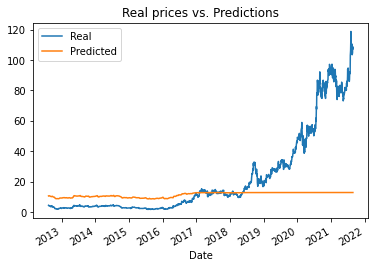

In [82]:
# Not even close
amd_prices.plot(title="Real prices vs. Predictions")